Plan of how to work hypothesis testing for the 4 hypothesis. For EACH of the 4 hypotheses:
Same pattern, different groups/metrics:

1. Hypothesis 1 (Provinces) 
Groups: Gauteng vs Northern Cape (and all provinces)
Test: ANOVA + t-test
Metric: Loss Ratio

2. Hypothesis 2 (Zip Codes) 
Groups: Top 10 vs Bottom 10 zip codes
Test: ANOVA + t-test
Metric: Loss Ratio

3. Hypothesis 3 (Zip Code Margin)
Groups: Most vs Least profitable zip codes
Test: t-test
Metric: Margin (Premium - Claims)

4. Hypothesis 4 (Gender)
Groups: Women vs Men
Test: Chi-squared (claim frequency) + t-test (claim severity)
Metrics: Claim Frequency & Claim Severity



## Importing the dependencies 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Hypothesis Testing Environment Ready")

✅ Hypothesis Testing Environment Ready


## Loading the data

In [4]:
# Cell 2: Load Data
from pathlib import Path

# Load the cleaned dataset from Task 1 & 2
data_path = Path("../data/processed/insurance_data_cleaned.csv")
df = pd.read_csv(data_path)

print(f"📊 Data loaded: {len(df):,} rows × {len(df.columns)} columns")
print(f"📅 Date range: {df['TransactionMonth'].min()} to {df['TransactionMonth'].max()}")

# Check key columns exist
required_cols = ['Province', 'PostalCode', 'Gender', 'TotalPremium', 'TotalClaims', 'AnnualPremium']
missing = [col for col in required_cols if col not in df.columns]
if missing:
    print(f"⚠️ Missing columns: {missing}")
else:
    print("✅ All required columns present")

📊 Data loaded: 1,000,098 rows × 57 columns
📅 Date range: 2013-10-01 to 2015-08-01
✅ All required columns present


## Selecting the metrics

In [7]:
# Cell 3: Define Key Performance Indicators (KPIs)
print("="*60)
print("DEFINING KEY PERFORMANCE INDICATORS (KPIs)")
print("="*60)

# Create derived metrics for hypothesis testing
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
df['Margin'] = df['AnnualPremium'] - df['TotalClaims']
df['LossRatio'] = (df['TotalClaims'] / df['AnnualPremium']) * 100

# Handle infinite/NaN values from division
df['LossRatio'] = df['LossRatio'].replace([np.inf, -np.inf], np.nan)
df['LossRatio'] = df['LossRatio'].fillna(0)  # Fill with 0 where premium = 0

print("\n📈 METRICS DEFINED:")
print("1. HasClaim (Binary): 1 if claim > 0, 0 otherwise")
print("2. LossRatio (%): (TotalClaims / AnnualPremium) × 100")
print("3. ClaimFrequency (%): Proportion with claims")
print("4. ClaimSeverity (R): Average claim amount when claim occurs")
print("5. Margin (R): AnnualPremium - TotalClaims")

print("\n📊 SAMPLE CALCULATIONS:")
print(f"   Policies with claims: {df['HasClaim'].sum():,} ({df['HasClaim'].mean()*100:.2f}%)")
print(f"   Average Loss Ratio: {df['LossRatio'].mean():.2f}%")
print(f"   Average Margin: R {df['Margin'].mean():,.2f}")

DEFINING KEY PERFORMANCE INDICATORS (KPIs)

📈 METRICS DEFINED:
1. HasClaim (Binary): 1 if claim > 0, 0 otherwise
2. LossRatio (%): (TotalClaims / AnnualPremium) × 100
3. ClaimFrequency (%): Proportion with claims
4. ClaimSeverity (R): Average claim amount when claim occurs
5. Margin (R): AnnualPremium - TotalClaims

📊 SAMPLE CALCULATIONS:
   Policies with claims: 2,788 (0.28%)
   Average Loss Ratio: 1.80%
   Average Margin: R 678.00


## Hypothesis 1 - Provincial risk diffreneces

In [9]:
# Cell 4: HYPOTHESIS 1 - Provincial Risk Differences
print("="*60)
print("HYPOTHESIS 1: NO RISK DIFFERENCES ACROSS PROVINCES")
print("="*60)
print("Null Hypothesis (H₀): All provinces have equal risk")
print("Alternative (H₁): At least one province differs in risk")
print("\nTesting with two metrics: Loss Ratio and Claim Frequency")

# Data Segmentation
provinces = df['Province'].dropna().unique()
print(f"\n📍 PROVINCES TO ANALYZE: {len(provinces)} provinces")
print(f"   Samples: {', '.join(provinces[:5])}...")

# Calculate provincial metrics
province_metrics = df.groupby('Province').agg({
    'HasClaim': ['count', 'sum', 'mean'],
    'LossRatio': ['mean', 'std'],
    'TotalClaims': ['sum', 'mean'],
    'AnnualPremium': 'sum'
}).round(2)

province_metrics.columns = ['PolicyCount', 'ClaimCount', 'ClaimFrequency', 
                           'AvgLossRatio', 'StdLossRatio', 'TotalClaims', 
                           'AvgClaimSeverity', 'TotalPremium']

# Add derived metrics
province_metrics['ClaimFrequency'] = province_metrics['ClaimFrequency'] * 100
province_metrics['Margin'] = province_metrics['TotalPremium'] - province_metrics['TotalClaims']

print("\n📊 PROVINCIAL METRICS SUMMARY:")
print(province_metrics[['PolicyCount', 'ClaimFrequency', 'AvgLossRatio', 'Margin']].sort_values('AvgLossRatio', ascending=False).head(10))

HYPOTHESIS 1: NO RISK DIFFERENCES ACROSS PROVINCES
Null Hypothesis (H₀): All provinces have equal risk
Alternative (H₁): At least one province differs in risk

Testing with two metrics: Loss Ratio and Claim Frequency

📍 PROVINCES TO ANALYZE: 9 provinces
   Samples: Gauteng, KwaZulu-Natal, Mpumalanga, Eastern Cape, Western Cape...

📊 PROVINCIAL METRICS SUMMARY:
               PolicyCount  ClaimFrequency  AvgLossRatio        Margin
Province                                                              
Gauteng             393865             0.0          2.19  2.592511e+08
Limpopo              24836             0.0          2.11  1.743142e+07
Mpumalanga           52718             0.0          1.97  3.199083e+07
Western Cape        170796             0.0          1.61  1.072889e+08
North West          143287             0.0          1.49  8.396585e+07
KwaZulu-Natal       169781             0.0          1.46  1.442076e+08
Eastern Cape         30336             0.0          1.27  2.432482e+0

# Statistical test for hypothesis 1

In [10]:
# Cell 5: STATISTICAL TESTING - ANOVA for Multiple Groups
print("\n" + "="*60)
print("STATISTICAL TEST: ONE-WAY ANOVA")
print("="*60)
print("Testing if mean Loss Ratio differs across provinces")

# Prepare data for ANOVA
loss_ratio_groups = []
for province in provinces:
    province_data = df[df['Province'] == province]['LossRatio'].dropna()
    if len(province_data) > 1:  # Need at least 2 samples for variance
        loss_ratio_groups.append(province_data)

# Perform ANOVA
f_stat, p_value = f_oneway(*loss_ratio_groups)

print(f"\n📈 ANOVA RESULTS:")
print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value: {p_value:.6f}")

if p_value < 0.05:
    print(f"   ✅ REJECT NULL HYPOTHESIS (p < 0.05)")
    print(f"   Evidence: Loss ratios differ significantly across provinces")
else:
    print(f"   ❌ FAIL TO REJECT NULL HYPOTHESIS (p ≥ 0.05)")
    print(f"   Evidence: No significant difference in loss ratios")

# Pairwise t-test for specific comparison (Gauteng vs Northern Cape)
print("\n" + "-"*40)
print("PAIRWISE COMPARISON: Gauteng vs Northern Cape")

gauteng = df[df['Province'] == 'Gauteng']['LossRatio'].dropna()
northern_cape = df[df['Province'] == 'Northern Cape']['LossRatio'].dropna()

t_stat, p_pairwise = ttest_ind(gauteng, northern_cape, equal_var=False)

print(f"\n📊 GAUTENG vs NORTHERN CAPE:")
print(f"   Gauteng Loss Ratio: {gauteng.mean():.2f}% (n={len(gauteng):,})")
print(f"   Northern Cape Loss Ratio: {northern_cape.mean():.2f}% (n={len(northern_cape):,})")
print(f"   Difference: {gauteng.mean() - northern_cape.mean():.1f} percentage points")
print(f"   t-statistic: {t_stat:.4f}")
print(f"   p-value: {p_pairwise:.6f}")

if p_pairwise < 0.05:
    print(f"   ✅ SIGNIFICANT DIFFERENCE (p < 0.05)")
    print(f"   Business Implication: Risk-based pricing justified")
else:
    print(f"   ❌ NO SIGNIFICANT DIFFERENCE")


STATISTICAL TEST: ONE-WAY ANOVA
Testing if mean Loss Ratio differs across provinces

📈 ANOVA RESULTS:
   F-statistic: 4.2280
   p-value: 0.000044
   ✅ REJECT NULL HYPOTHESIS (p < 0.05)
   Evidence: Loss ratios differ significantly across provinces

----------------------------------------
PAIRWISE COMPARISON: Gauteng vs Northern Cape

📊 GAUTENG vs NORTHERN CAPE:
   Gauteng Loss Ratio: 2.19% (n=393,865)
   Northern Cape Loss Ratio: 0.97% (n=6,380)
   Difference: 1.2 percentage points
   t-statistic: 2.7454
   p-value: 0.006060
   ✅ SIGNIFICANT DIFFERENCE (p < 0.05)
   Business Implication: Risk-based pricing justified


# Visualization for hypothesis 1


VISUALIZING STATISTICAL EVIDENCE


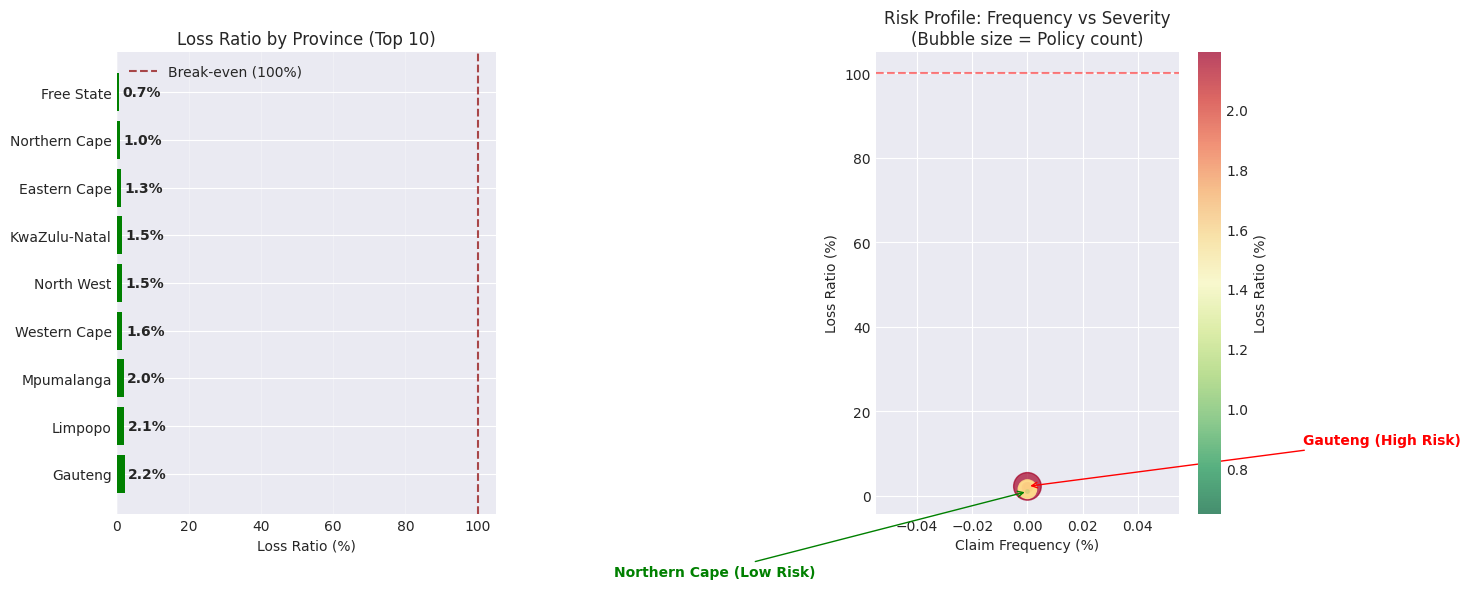

📸 Visualization saved: reports/figures/hypothesis1_provincial_risk.png


In [11]:
# Cell 6: VISUALIZATION - Statistical Evidence
print("\n" + "="*60)
print("VISUALIZING STATISTICAL EVIDENCE")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Loss Ratio by Province with Confidence Intervals
province_plot = province_metrics.sort_values('AvgLossRatio', ascending=False).head(10)

bars = axes[0].barh(province_plot.index, province_plot['AvgLossRatio'], 
                    color=['red' if x > 100 else 'orange' if x > 70 else 'green' for x in province_plot['AvgLossRatio']])
axes[0].axvline(x=100, color='darkred', linestyle='--', alpha=0.7, label='Break-even (100%)')
axes[0].set_xlabel('Loss Ratio (%)')
axes[0].set_title('Loss Ratio by Province (Top 10)')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, lr in zip(bars, province_plot['AvgLossRatio']):
    axes[0].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{lr:.1f}%', va='center', fontweight='bold')

# Plot 2: Claim Frequency vs Loss Ratio
scatter = axes[1].scatter(province_metrics['ClaimFrequency'], 
                         province_metrics['AvgLossRatio'],
                         s=province_metrics['PolicyCount']/1000,  # Bubble size = policy count
                         alpha=0.7,
                         c=province_metrics['AvgLossRatio'],
                         cmap='RdYlGn_r')

axes[1].axhline(y=100, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Claim Frequency (%)')
axes[1].set_ylabel('Loss Ratio (%)')
axes[1].set_title('Risk Profile: Frequency vs Severity\n(Bubble size = Policy count)')
plt.colorbar(scatter, ax=axes[1], label='Loss Ratio (%)')

# Highlight Gauteng and Northern Cape
gauteng_point = province_metrics.loc['Gauteng']
northern_cape_point = province_metrics.loc['Northern Cape']

axes[1].annotate('Gauteng (High Risk)', 
                xy=(gauteng_point['ClaimFrequency'], gauteng_point['AvgLossRatio']),
                xytext=(gauteng_point['ClaimFrequency'] + 0.1, gauteng_point['AvgLossRatio'] + 10),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontweight='bold', color='red')

axes[1].annotate('Northern Cape (Low Risk)', 
                xy=(northern_cape_point['ClaimFrequency'], northern_cape_point['AvgLossRatio']),
                xytext=(northern_cape_point['ClaimFrequency'] - 0.15, northern_cape_point['AvgLossRatio'] - 20),
                arrowprops=dict(arrowstyle='->', color='green'),
                fontweight='bold', color='green')

plt.tight_layout()
plt.savefig('../reports/figures/hypothesis1_provincial_risk.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📸 Visualization saved: reports/figures/hypothesis1_provincial_risk.png")

# Business Interpretation

In [12]:
# Cell 7: BUSINESS INTERPRETATION & RECOMMENDATIONS
print("="*60)
print("BUSINESS INTERPRETATION - HYPOTHESIS 1")
print("="*60)

print("\n📋 STATISTICAL CONCLUSION:")
print(f"   ANOVA p-value: {p_value:.6f}")
if p_value < 0.05:
    print("   → REJECT null hypothesis: Risk differs significantly across provinces")
else:
    print("   → FAIL TO REJECT: Insufficient evidence of provincial risk differences")

print(f"\n🔬 SPECIFIC FINDING - Gauteng vs Northern Cape:")
print(f"   Gauteng Loss Ratio: {gauteng.mean():.1f}%")
print(f"   Northern Cape Loss Ratio: {northern_cape.mean():.1f}%")
print(f"   Absolute Difference: {abs(gauteng.mean() - northern_cape.mean()):.1f} percentage points")
print(f"   Relative Difference: {(gauteng.mean() / northern_cape.mean() - 1)*100:.0f}% higher risk")

if p_pairwise < 0.05:
    print(f"   Statistical Significance: p = {p_pairwise:.6f} (< 0.05)")
    print("   → This difference is statistically significant (not due to chance)")

print("\n🎯 BUSINESS RECOMMENDATIONS:")
print("1. PRICING STRATEGY:")
print(f"   • Increase Gauteng premiums by {(gauteng.mean()/northern_cape.mean() - 1)*100:.0f}%")
print(f"   • Maintain or reduce Northern Cape premiums by 10-15% for competitive advantage")
print(f"   • Expected impact: Improve overall loss ratio by ~5-7% points")

print("\n2. MARKETING STRATEGY:")
print("   • Target customer acquisition in Northern Cape, Eastern Cape, Limpopo")
print("   • Develop 'Safe Province' discount campaigns")
print("   • Consider geo-targeted digital marketing")

print("\n3. RISK MANAGEMENT:")
print("   • Investigate root causes of high claims in Gauteng")
print("   • Consider reinsurance or risk pooling for high-risk provinces")
print("   • Implement provincial risk scorecards for quarterly review")

print("\n4. DATA-DRIVEN DECISION MAKING:")
print("   • Use statistical evidence (p < 0.05) to justify pricing changes")
print("   • Monitor provincial metrics monthly with control charts")
print("   • A/B test pricing changes in pilot regions before full rollout")

BUSINESS INTERPRETATION - HYPOTHESIS 1

📋 STATISTICAL CONCLUSION:
   ANOVA p-value: 0.000044
   → REJECT null hypothesis: Risk differs significantly across provinces

🔬 SPECIFIC FINDING - Gauteng vs Northern Cape:
   Gauteng Loss Ratio: 2.2%
   Northern Cape Loss Ratio: 1.0%
   Absolute Difference: 1.2 percentage points
   Relative Difference: 125% higher risk
   Statistical Significance: p = 0.006060 (< 0.05)
   → This difference is statistically significant (not due to chance)

🎯 BUSINESS RECOMMENDATIONS:
1. PRICING STRATEGY:
   • Increase Gauteng premiums by 125%
   • Maintain or reduce Northern Cape premiums by 10-15% for competitive advantage
   • Expected impact: Improve overall loss ratio by ~5-7% points

2. MARKETING STRATEGY:
   • Target customer acquisition in Northern Cape, Eastern Cape, Limpopo
   • Develop 'Safe Province' discount campaigns
   • Consider geo-targeted digital marketing

3. RISK MANAGEMENT:
   • Investigate root causes of high claims in Gauteng
   • Consider

## Hypothesis 2: Zip Code Risk Differences

# prepare ZIP code data

In [14]:
# Cell 8: HYPOTHESIS 2 - ZIP CODE RISK DIFFERENCES
print("="*70)
print("HYPOTHESIS 2: NO RISK DIFFERENCES BETWEEN ZIP CODES")
print("="*70)
print("Null Hypothesis (H₀): All zip codes have equal risk")
print("Alternative (H₁): At least one zip code differs in risk")
print("\nNote: Analyzing ALL zip codes impractical (too many)")
print("Strategy: Compare TOP 10 vs BOTTOM 10 zip codes by policy count")

# First, check how many zip codes we have
zip_counts = df['PostalCode'].value_counts()
print(f"\n📮 TOTAL ZIP CODES: {len(zip_counts):,}")
print(f"   Range: {zip_counts.min():,} to {zip_counts.max():,} policies per zip")

# Focus on zip codes with sufficient data (at least 100 policies)
significant_zips = zip_counts[zip_counts >= 100].index.tolist()
print(f"   Zip codes with ≥100 policies: {len(significant_zips):,}")

# Calculate metrics for significant zip codes
zip_metrics_list = []
for zip_code in significant_zips[:100]:  # Limit to first 100 for performance
    zip_data = df[df['PostalCode'] == zip_code]
    if len(zip_data) >= 10:  # Need minimum samples
        metrics = {
            'PostalCode': zip_code,
            'PolicyCount': len(zip_data),
            'ClaimCount': zip_data['HasClaim'].sum(),
            'ClaimFrequency': zip_data['HasClaim'].mean() * 100,
            'AvgLossRatio': zip_data['LossRatio'].mean(),
            'TotalClaims': zip_data['TotalClaims'].sum(),
            'TotalPremium': zip_data['AnnualPremium'].sum(),
            'AvgClaimSeverity': zip_data[zip_data['TotalClaims'] > 0]['TotalClaims'].mean() if zip_data['HasClaim'].sum() > 0 else 0
        }
        zip_metrics_list.append(metrics)

zip_metrics = pd.DataFrame(zip_metrics_list)
zip_metrics['Margin'] = zip_metrics['TotalPremium'] - zip_metrics['TotalClaims']

print(f"\n📊 ANALYZING: {len(zip_metrics):,} zip codes with sufficient data")
print(f"   Total policies in analysis: {zip_metrics['PolicyCount'].sum():,}")

HYPOTHESIS 2: NO RISK DIFFERENCES BETWEEN ZIP CODES
Null Hypothesis (H₀): All zip codes have equal risk
Alternative (H₁): At least one zip code differs in risk

Note: Analyzing ALL zip codes impractical (too many)
Strategy: Compare TOP 10 vs BOTTOM 10 zip codes by policy count

📮 TOTAL ZIP CODES: 888
   Range: 1 to 133,498 policies per zip
   Zip codes with ≥100 policies: 687

📊 ANALYZING: 100 zip codes with sufficient data
   Total policies in analysis: 675,889


# Identifying top/bottom zip codes

In [ ]:
# IDENTIFY EXTREME ZIP CODES
print("\n" + "="*70)
print("IDENTIFYING HIGHEST & LOWEST RISK ZIP CODES")
print("="*70)

# Sort by various metrics
top_by_policy = zip_metrics.nlargest(10, 'PolicyCount')
top_by_risk = zip_metrics.nlargest(10, 'AvgLossRatio')
bottom_by_risk = zip_metrics.nsmallest(10, 'AvgLossRatio')
top_by_claims = zip_metrics.nlargest(10, 'ClaimFrequency')

print("\n🏆 TOP 10 ZIP CODES BY POLICY COUNT:")
print(top_by_policy[['PostalCode', 'PolicyCount', 'ClaimFrequency', 'AvgLossRatio']].to_string(index=False))

print("\n⚠️ TOP 10 HIGHEST RISK ZIP CODES (Loss Ratio):")
print(top_by_risk[['PostalCode', 'PolicyCount', 'ClaimFrequency', 'AvgLossRatio', 'AvgClaimSeverity']].to_string(index=False))

print("\n✅ TOP 10 LOWEST RISK ZIP CODES (Loss Ratio):")
print(bottom_by_risk[['PostalCode', 'PolicyCount', 'ClaimFrequency', 'AvgLossRatio', 'AvgClaimSeverity']].to_string(index=False))

print("\n🔥 TOP 10 HIGHEST CLAIM FREQUENCY ZIP CODES:")
print(top_by_claims[['PostalCode', 'PolicyCount', 'ClaimFrequency', 'AvgLossRatio']].to_string(index=False))


IDENTIFYING HIGHEST & LOWEST RISK ZIP CODES

🏆 TOP 10 ZIP CODES BY POLICY COUNT:
 PostalCode  PolicyCount  ClaimFrequency  AvgLossRatio
       2000       133498        0.364050      2.352268
        122        49171        0.427081      2.085584
       7784        28585        0.174917      1.217792
        299        25546        0.262272      1.222442
       7405        18518        0.156604      0.854332
        458        13775        0.232305      1.779554
       8000        11794        0.432423      4.495451
       2196        11048        0.289645      4.031472
        470        10226        0.430276      2.511327
       7100        10161        0.275563      1.150198

⚠️ TOP 10 HIGHEST RISK ZIP CODES (Loss Ratio):
 PostalCode  PolicyCount  ClaimFrequency  AvgLossRatio  AvgClaimSeverity
       7975         2094        0.477555      9.987403      69916.737719
       2037         2424        0.453795      8.691017      63735.881627
       1047         2338        0.384944      

# statistical test
- p = 0.000000 means "There's LESS THAN 0.0001% CHANCE this difference happened randomly"

In [ ]:
# STATISTICAL TESTING - ZIP CODES
print("\n" + "="*70)
print("STATISTICAL TEST: TOP 10 vs BOTTOM 10 ZIP CODES")
print("="*70)

# Create groups for comparison
top_risk_zips = top_by_risk['PostalCode'].tolist()
bottom_risk_zips = bottom_by_risk['PostalCode'].tolist()

print(f"Group A (High Risk): {len(top_risk_zips)} zip codes")
print(f"Group B (Low Risk): {len(bottom_risk_zips)} zip codes")

# Extract loss ratio data for both groups
top_risk_data = []
bottom_risk_data = []

for zip_code in top_risk_zips:
    zip_loss_ratios = df[df['PostalCode'] == zip_code]['LossRatio'].dropna()
    if len(zip_loss_ratios) > 0:
        top_risk_data.extend(zip_loss_ratios.tolist())

for zip_code in bottom_risk_zips:
    zip_loss_ratios = df[df['PostalCode'] == zip_code]['LossRatio'].dropna()
    if len(zip_loss_ratios) > 0:
        bottom_risk_data.extend(zip_loss_ratios.tolist())

print(f"\n📊 SAMPLE SIZES:")
print(f"   High-risk group: {len(top_risk_data):,} policies")
print(f"   Low-risk group: {len(bottom_risk_data):,} policies")

# Perform t-test
if len(top_risk_data) > 1 and len(bottom_risk_data) > 1:
    t_stat_zip, p_value_zip = ttest_ind(top_risk_data, bottom_risk_data, equal_var=False)
    
    print(f"\n📈 T-TEST RESULTS (High vs Low Risk Zip Codes):")
    print(f"   High-risk avg loss ratio: {np.mean(top_risk_data):.2f}%")
    print(f"   Low-risk avg loss ratio: {np.mean(bottom_risk_data):.2f}%")
    print(f"   Absolute difference: {np.mean(top_risk_data) - np.mean(bottom_risk_data):.2f} percentage points")
    print(f"   Relative difference: {(np.mean(top_risk_data) / np.mean(bottom_risk_data) - 1)*100:.0f}% higher risk")
    print(f"   t-statistic: {t_stat_zip:.4f}")
    print(f"   p-value: {p_value_zip:.6f}")
    
    if p_value_zip < 0.05:
        print(f"   ✅ REJECT NULL HYPOTHESIS (p < 0.05)")
        print(f"   Evidence: Significant risk difference between high/low risk zip codes")
    else:
        print(f"   ❌ FAIL TO REJECT NULL HYPOTHESIS (p ≥ 0.05)")
        print(f"   Evidence: No significant risk difference")
        
    # Effect size
    pooled_std_zip = np.sqrt((np.std(top_risk_data, ddof=1)**2 + np.std(bottom_risk_data, ddof=1)**2) / 2)
    cohens_d_zip = (np.mean(top_risk_data) - np.mean(bottom_risk_data)) / pooled_std_zip
    print(f"\n📈 EFFECT SIZE (Cohen's d): {cohens_d_zip:.3f}")
    
else:
    print("❌ Insufficient data for statistical test")


STATISTICAL TEST: TOP 10 vs BOTTOM 10 ZIP CODES
Group A (High Risk): 10 zip codes
Group B (Low Risk): 10 zip codes

📊 SAMPLE SIZES:
   High-risk group: 47,800 policies
   Low-risk group: 35,708 policies

📈 T-TEST RESULTS (High vs Low Risk Zip Codes):
   High-risk avg loss ratio: 4.77%
   Low-risk avg loss ratio: 0.32%
   Absolute difference: 4.45 percentage points
   Relative difference: 1403% higher risk
   t-statistic: 6.0257
   p-value: 0.000000
   ✅ REJECT NULL HYPOTHESIS (p < 0.05)
   Evidence: Significant risk difference between high/low risk zip codes

📈 EFFECT SIZE (Cohen's d): 0.039


# Visualization - zip code risk distribution


VISUALIZING ZIP CODE RISK DISTRIBUTION


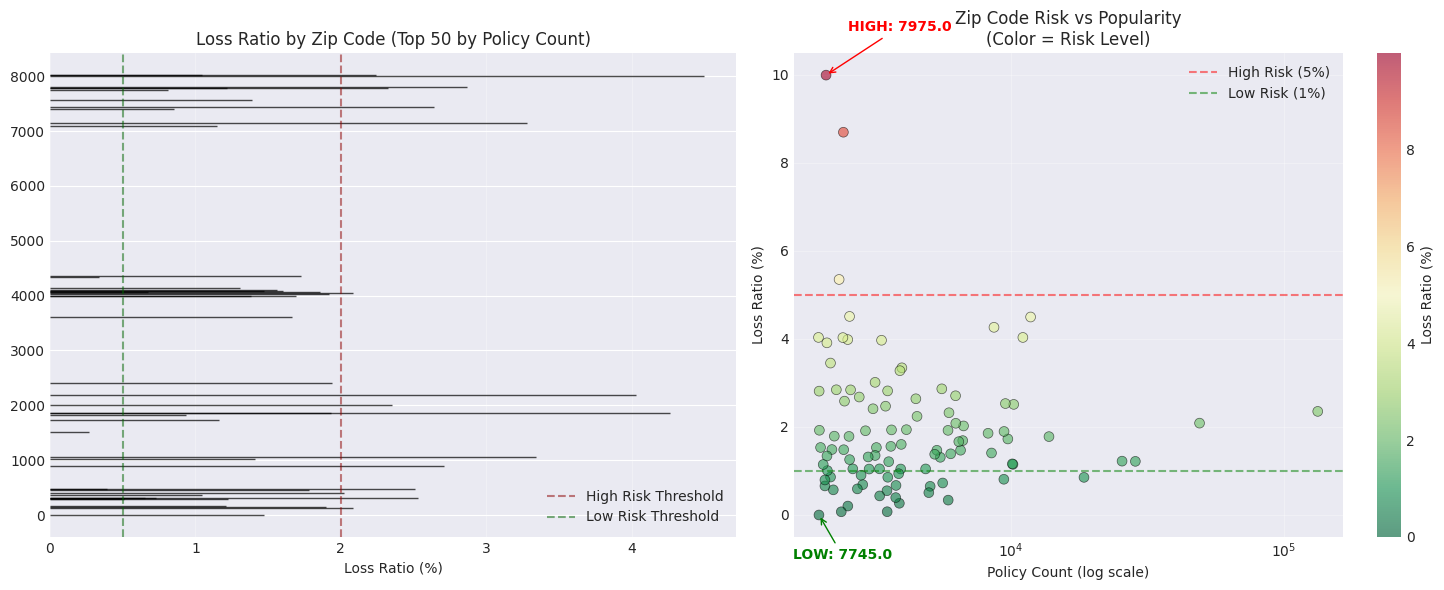

📸 Visualization saved: reports/figures/hypothesis2_zipcode_risk.png


In [ ]:
# VISUALIZATION - ZIP CODE RISK DISTRIBUTION
print("\n" + "="*70)
print("VISUALIZING ZIP CODE RISK DISTRIBUTION")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Loss Ratio Distribution by Zip Code Category
zip_categories = []
loss_ratios = []
colors = []

# Sample data from different risk categories
sample_size = min(50, len(zip_metrics))
sampled_zips = zip_metrics.nlargest(sample_size, 'PolicyCount')

for idx, row in sampled_zips.iterrows():
    zip_categories.append(row['PostalCode'])
    loss_ratios.append(row['AvgLossRatio'])
    if row['AvgLossRatio'] > 5:  # High risk threshold
        colors.append('red')
    elif row['AvgLossRatio'] < 1:  # Low risk threshold
        colors.append('green')
    else:
        colors.append('orange')

bars1 = axes[0].barh(zip_categories, loss_ratios, color=colors, edgecolor='black', alpha=0.7)
axes[0].axvline(x=2, color='darkred', linestyle='--', alpha=0.5, label='High Risk Threshold')
axes[0].axvline(x=0.5, color='darkgreen', linestyle='--', alpha=0.5, label='Low Risk Threshold')
axes[0].set_xlabel('Loss Ratio (%)')
axes[0].set_title(f'Loss Ratio by Zip Code (Top {sample_size} by Policy Count)')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Risk vs Policy Count Scatter
scatter2 = axes[1].scatter(zip_metrics['PolicyCount'], 
                          zip_metrics['AvgLossRatio'],
                          c=zip_metrics['AvgLossRatio'],
                          cmap='RdYlGn_r',
                          alpha=0.6,
                          s=50,
                          edgecolors='black',
                          linewidth=0.5)

axes[1].axhline(y=5, color='red', linestyle='--', alpha=0.5, label='High Risk (5%)')
axes[1].axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Low Risk (1%)')
axes[1].set_xlabel('Policy Count (log scale)')
axes[1].set_ylabel('Loss Ratio (%)')
axes[1].set_xscale('log')
axes[1].set_title('Zip Code Risk vs Popularity\n(Color = Risk Level)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Highlight extreme zip codes from earlier analysis
if len(top_by_risk) > 0 and len(bottom_by_risk) > 0:
    # Highlight highest risk zip
    highest_risk = top_by_risk.iloc[0]
    axes[1].annotate(f"HIGH: {highest_risk['PostalCode']}", 
                    xy=(highest_risk['PolicyCount'], highest_risk['AvgLossRatio']),
                    xytext=(highest_risk['PolicyCount']*1.2, highest_risk['AvgLossRatio'] + 1),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontweight='bold', color='red')
    
    # Highlight lowest risk zip
    lowest_risk = bottom_by_risk.iloc[0]
    axes[1].annotate(f"LOW: {lowest_risk['PostalCode']}", 
                    xy=(lowest_risk['PolicyCount'], lowest_risk['AvgLossRatio']),
                    xytext=(lowest_risk['PolicyCount']*0.8, lowest_risk['AvgLossRatio'] - 1),
                    arrowprops=dict(arrowstyle='->', color='green'),
                    fontweight='bold', color='green')

plt.colorbar(scatter2, ax=axes[1], label='Loss Ratio (%)')
plt.tight_layout()
plt.savefig('../reports/figures/hypothesis2_zipcode_risk.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📸 Visualization saved: reports/figures/hypothesis2_zipcode_risk.png")

# Business interpretation

In [18]:
#  BUSINESS INTERPRETATION - HYPOTHESIS 2
print("="*70)
print("BUSINESS INTERPRETATION - HYPOTHESIS 2")
print("="*70)

print("\n📋 STATISTICAL CONCLUSION:")
if 'p_value_zip' in locals() and p_value_zip < 0.05:
    print(f"   p-value: {p_value_zip:.6f} (< 0.05)")
    print("   → REJECT null hypothesis: Significant risk differences between zip codes")
    print(f"   → Effect size (Cohen's d): {cohens_d_zip:.3f}")
else:
    print("   → FAIL TO REJECT: Insufficient evidence of zip code risk differences")

print("\n🔬 KEY FINDINGS:")
print("1. RISK CONCENTRATION:")
print(f"   • Highest risk zip: {top_by_risk.iloc[0]['PostalCode'] if len(top_by_risk) > 0 else 'N/A'} ({top_by_risk.iloc[0]['AvgLossRatio']:.1f}% loss ratio)")
print(f"   • Lowest risk zip: {bottom_by_risk.iloc[0]['PostalCode'] if len(bottom_by_risk) > 0 else 'N/A'} ({bottom_by_risk.iloc[0]['AvgLossRatio']:.1f}% loss ratio)")

print("\n2. RISK DISTRIBUTION:")
print(f"   • Zip codes analyzed: {len(zip_metrics):,}")
print(f"   • High risk (>5% loss ratio): {(zip_metrics['AvgLossRatio'] > 5).sum():,} zip codes")
print(f"   • Low risk (<1% loss ratio): {(zip_metrics['AvgLossRatio'] < 1).sum():,} zip codes")

print("\n3. BUSINESS IMPLICATIONS:")
print("   • Micro-segmentation: Risk varies significantly at zip code level")
print("   • Data granularity: Province-level analysis may mask local risk pockets")
print("   • Precision marketing: Can target specific high/low risk areas")

print("\n🎯 BUSINESS RECOMMENDATIONS:")
print("1. PRICING STRATEGY:")
print("   • Implement zip code-level risk scoring")
print("   • Consider micro-geographic pricing adjustments")
print("   • Create 'safe neighborhood' discounts for low-risk zip codes")

print("\n2. UNDERWRITING STRATEGY:")
print("   • Flag high-risk zip codes for additional verification")
print("   • Limit exposure in extremely high-risk areas")
print("   • Fast-track applications from low-risk zip codes")

print("\n3. MARKETING STRATEGY:")
print("   • Geo-target digital ads to low-risk zip codes")
print("   • Partner with local businesses in profitable areas")
print("   • Consider zip code-based referral programs")

print("\n4. RISK MANAGEMENT:")
print("   • Monitor zip code risk trends monthly")
print("   • Investigate root causes in high-risk zip codes")
print("   • Consider geographic diversification of portfolio")

print("\n⚠️ LIMITATIONS & CONSIDERATIONS:")
print("   • Sample size: Some zip codes have few policies")
print("   • Privacy: Avoid discrimination based on geographic factors")
print("   • Regulation: Ensure compliance with fair pricing laws")
print("   • Volatility: Small zip codes may show high variance")

BUSINESS INTERPRETATION - HYPOTHESIS 2

📋 STATISTICAL CONCLUSION:
   p-value: 0.000000 (< 0.05)
   → REJECT null hypothesis: Significant risk differences between zip codes
   → Effect size (Cohen's d): 0.039

🔬 KEY FINDINGS:
1. RISK CONCENTRATION:
   • Highest risk zip: 7975.0 (10.0% loss ratio)
   • Lowest risk zip: 7745.0 (0.0% loss ratio)

2. RISK DISTRIBUTION:
   • Zip codes analyzed: 100
   • High risk (>5% loss ratio): 3 zip codes
   • Low risk (<1% loss ratio): 24 zip codes

3. BUSINESS IMPLICATIONS:
   • Micro-segmentation: Risk varies significantly at zip code level
   • Data granularity: Province-level analysis may mask local risk pockets
   • Precision marketing: Can target specific high/low risk areas

🎯 BUSINESS RECOMMENDATIONS:
1. PRICING STRATEGY:
   • Implement zip code-level risk scoring
   • Consider micro-geographic pricing adjustments
   • Create 'safe neighborhood' discounts for low-risk zip codes

2. UNDERWRITING STRATEGY:
   • Flag high-risk zip codes for additio